In [1]:
import numpy as np
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import Angle, SkyCoord
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter as gf
from astropy.nddata import Cutout2D
import astropy.visualization as viz
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import astropy.coordinates as coords
from astropy.visualization.wcsaxes import WCSAxes
import astropy.visualization.wcsaxes.frame as frame
from astropy.table import Table
import pandas as pd
from scipy.stats import kde
import time
import pickle
import os
import reproject
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, Normalizer
from IPython.display import Image
import seaborn as sns

%matplotlib notebook
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## OBJECTIVE:
### (1) Test the stacking/coadding code on a few HSC sources with counterparts (they must have share similar magnitudes). If the resulting plot contains a source at the center of the image 🥳

### (2) Take those same sources and convert the image’s center-most pixels from flux units to magnitudes. If the resulting magnitude value is reasonable (near the shared values of the individual stacked sources), this will serve as a sanity check for my unit calculations. 

### (3) Depending on step 2 goes, I’ll determine the magnitudes for the stacked sources without counterparts across the g,r,i,z,and y bands by focusing on the center pixels and converting the flux to magnitudes. 


### Gathering HSC and Chandra Data

In [2]:
Chandra_Data = Table.read('Chandra_COSMOS_Legacy_20151120_4d.fits', format='fits').to_pandas()
HSC_Data = pd.read_csv("Color_COSMOS_DD.csv", dtype = np.float64).dropna(axis = 0, how = "any")

### Determining counterparts

In [3]:
#pickles contain all the data in a more manageable way!
with open('/Users/linaflorez/Desktop/ObsCos/COSMOS_research/venv/moredataHSC_skycoords.pkl', 'rb') as f:
    HSC_catalog = pickle.load(f)
with open('/Users/linaflorez/Desktop/ObsCos/COSMOS_research/venv/Chandra_skycoords.pkl', 'rb') as f:
    Chandra_catalog = pickle.load(f)

max_sep = 1.0 * u.arcsec
#idx1 indexes Chandra, #idx2 indexes HSC
idx1, idx2, sep2d, dist3d = search_around_sky(Chandra_catalog, HSC_catalog, max_sep) 
print("Number of matches:", len(idx1))

Number of matches: 5158


In [26]:
search_around_sky?

Signature: search_around_sky(coords1, coords2, seplimit, storekdtree='kdtree_sky')
Docstring:
Searches for pairs of points that have an angular separation at least as
close as a specified angle.

This is intended for use on coordinate objects with arrays of coordinates,
not scalars.  For scalar coordinates, it is better to use the ``separation``
methods.

Parameters
----------
coords1 : `~astropy.coordinates.BaseCoordinateFrame` or `~astropy.coordinates.SkyCoord`
    The first set of coordinates, which will be searched for matches from
    ``coords2`` within ``seplimit``. Cannot be a scalar coordinate.
coords2 : `~astropy.coordinates.BaseCoordinateFrame` or `~astropy.coordinates.SkyCoord`
    The second set of coordinates, which will be searched for matches from
    ``coords1`` within ``seplimit``. Cannot be a scalar coordinate.
seplimit : `~astropy.units.Quantity` with angle units
    The on-sky separation to search within.
storekdtree : bool or str, optional
    If a string, will sto

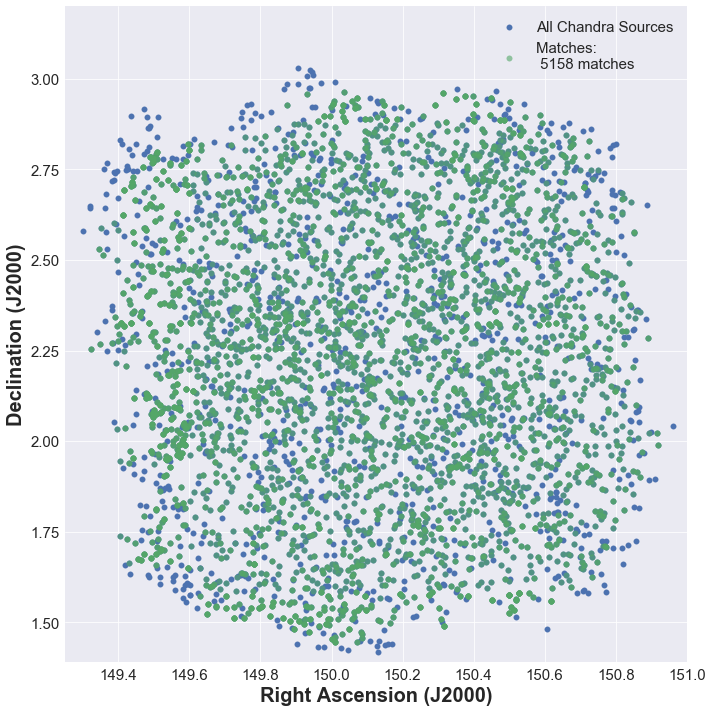

In [28]:
plt.style.use("seaborn-paper")
plt.figure(figsize = (10,10))
plt.scatter(Chandra_catalog.ra, Chandra_catalog.dec, label = "All Chandra Sources")
plt.scatter(Chandra_catalog.ra[idx1], Chandra_catalog.dec[idx1], alpha = 0.6, label = "Matches: \n %i matches" % (len(idx1)))
plt.xlim(149.25,151)
plt.ylim(1.39, 3.2)
plt.xlabel("Right Ascension (J2000)", weight = "bold", size = 20)
plt.ylabel("Declination (J2000)", weight = "bold", size = 20)
plt.legend(loc = "upper right", prop={'size': 15})
plt.tick_params("both", labelsize = 15)
plt.tight_layout()
#plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Matches/Chandra_RAvDec.pdf")
plt.show()

In [242]:
matches = pd.DataFrame()
matches["ra"] = HSC_catalog[idx2].ra.value
matches["dec"] = HSC_catalog[idx2].dec.value
matches = matches.drop_duplicates(subset='ra', keep='first')
len(idx1)

5158

### Creating separate HSC and Chandra dataframes containing only sources with counterparts
(i.e. sources that have matches)

In [6]:
Chandra_matches = Chandra_catalog[idx1]
HSC_matches = HSC_Data.loc[HSC_Data["# ra"].isin(HSC_catalog[idx2].ra.value)]#.any()

### Getting sources with a certain G magnitude
I wanted to focus HSC sources that had counterparts & a gcmodel_magnitude of roughly 26

In [7]:
gcmodel_mag26ish = HSC_matches.loc[abs(26 - HSC_matches["gcmodel_mag"]) < 0.05][["# ra","dec"]][0:40:4]
gcmodel_mag26ish.to_csv("gcmodel_mag26ish.csv", index=False) #going to input this into hscmap

In [247]:
folder_path = "/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Restart/CheckingStackingG/"
ra = (gcmodel_mag26ish["# ra"]).astype(str)

## Making folders for all of the sources
# for folder in ra:
#     os.mkdir(os.path.join(folder_path,folder))

g_fits = []

# folder_path_name = "/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Restart/FITS_FILES"

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        if file.startswith("cutout-HSC-G"):
            g_fits.append([os.path.join(subdir, file).split(os.sep)[-2],os.path.join(subdir, file)])
            
g_fits = np.array(g_fits)

#Organizing the sources for handling later on
indices = []
for index_j,j in enumerate(ra.values):
    for index_i,i in enumerate(g_fits[:,0]):
        if j == i:
            indices.append(index_i)
gcmodel_mag26ish["gfits"] = g_fits[indices][:,1]

## Forming a dataframe of the newly acquired data, containing fits files and corresponding ra and dec info

In [201]:
df = pd.DataFrame()
df["ra"] = ra.astype("float")
df["dec"] = gcmodel_mag26ish["dec"].astype("float")
df["gfits"] = g_fits[indices][:,1]
df.to_csv("testing_layering_gband.csv")

## Layering function

In [519]:
def cutout_func(band, result):  
    num = np.zeros((18,18))
    denom = np.zeros((18,18))
    flux_mag0 = []
    
    for i in range(len(result)):
        #Getting RA and Dec of source for cutout
        respective_band = result[band].iloc[i]
        RA = result["ra"].iloc[i]
        DEC = result["dec"].iloc[i]
        hdulist = fits.open(respective_band)
        flux_mag0.append(hdulist[0].header["FLUXMAG0"])

        # Courtesy of hscMap 
        image = hdulist[1].data
        mask = hdulist[2].data
        variance = hdulist[3].data #for inverse variance

        # Prepping for cutout
        wcs = WCS(hdulist[1].header)
        coords = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree)
        cut_center = SkyCoord(coords)
        size = 3 #arcsecs
        cutout_size = np.array([size, size]) * u.arcsec

        # Doing a cutout on the image array
        cutout = Cutout2D(image, cut_center, cutout_size, wcs=wcs)

        # Doing a cutout on the variance array
        adjusted_var = Cutout2D(variance, cut_center, cutout_size, wcs=wcs).data

        #added on/stacked to initialized num/denom arrays
        num += cutout.data/adjusted_var 
        denom += 1/adjusted_var
    
    cutouts = num/denom 

    # Plotting stacked image!
    plt.style.use("dark_background")
    fig,(ax1) = plt.subplots(1,1, figsize = (20,10))
    title = "Stacking" + " " + band + " " + "files \n (for" + " " + str(result.shape[0]) + " " + "sources w/ counterparts)" 
    plt.title(title, weight = "bold", size = 20)
    plot = plt.imshow(cutouts, cmap = "plasma", extent=[-size/2 ,size/2,-size/2 ,size/2], aspect='auto')
    plt.contour(cutouts, 3, extent=[-size/2 ,size/2,-size/2 ,size/2],cmap='Greys')
    plt.xlabel("Arcsecs", weight = "bold", size = 20)
    plt.ylabel("Arcsecs", weight = "bold", size = 20)
    plt.tick_params("both", labelsize = 20)
    cbar = fig.colorbar(plot, label = "Flux Units")
    cbar.ax.tick_params(labelsize=20)
    plt.savefig("Testing_stacking.pdf")
    
    
    #Determining magnitude
    smaller_section = cutouts[6:12,6:12]
    magnitude = -2.5 * np.log10(np.sum(smaller_section)/flux_mag0[0])
    plt.style.use("dark_background")
    fig,(ax1) = plt.subplots(1,1, figsize = (20,10))
    title = "Central region (for " + str(result.shape[0]) + " stacked " + band  + " sources w/ counterparts)" +"\n" + "Magnitude = " + str(round(magnitude,2)) 
    plt.title(title, weight = "bold", size = 20)
    plot = plt.imshow(smaller_section, cmap = "plasma", extent=[-0.5 ,0.5,-0.5 ,0.5], aspect='auto')
    plt.contour(smaller_section, 2, extent=[-0.5 ,0.5,-0.5 ,0.5],cmap='Greys')
    plt.xlabel("Arcsecs", weight = "bold", size = 20)
    plt.ylabel("Arcsecs", weight = "bold", size = 20)
    plt.tick_params("both", labelsize = 20)
    cbar = fig.colorbar(plot, label = "Flux Units")
    cbar.ax.tick_params(labelsize=20, size = 20)
    plt.savefig("Testing_mag_calculation.pdf")
    


    
    return cutouts

## Testing the layering function

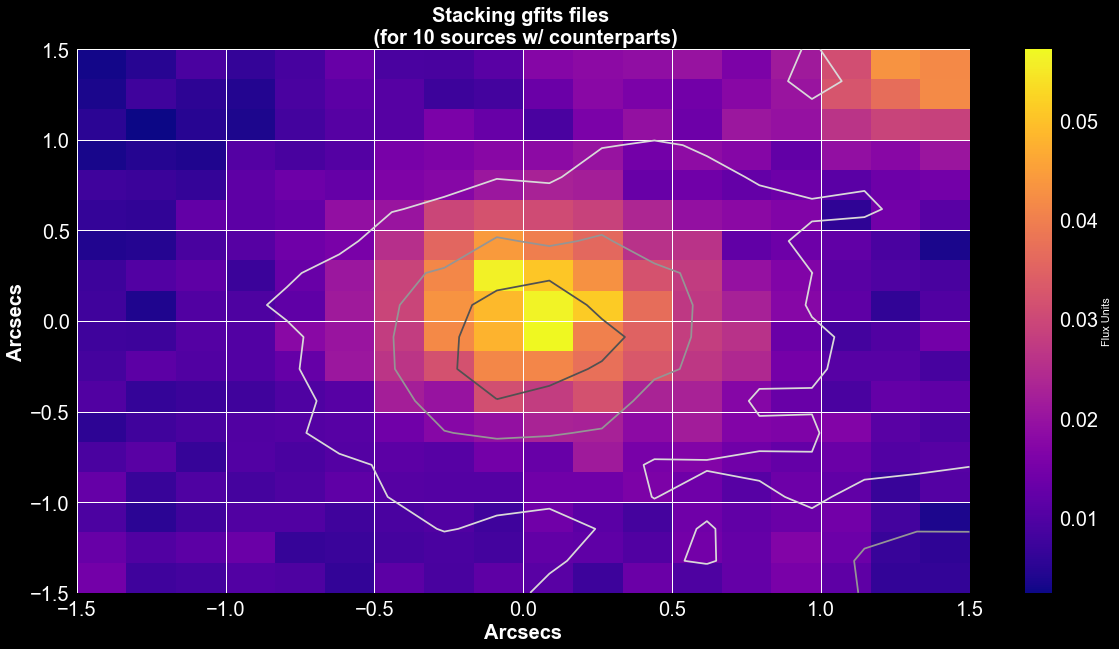

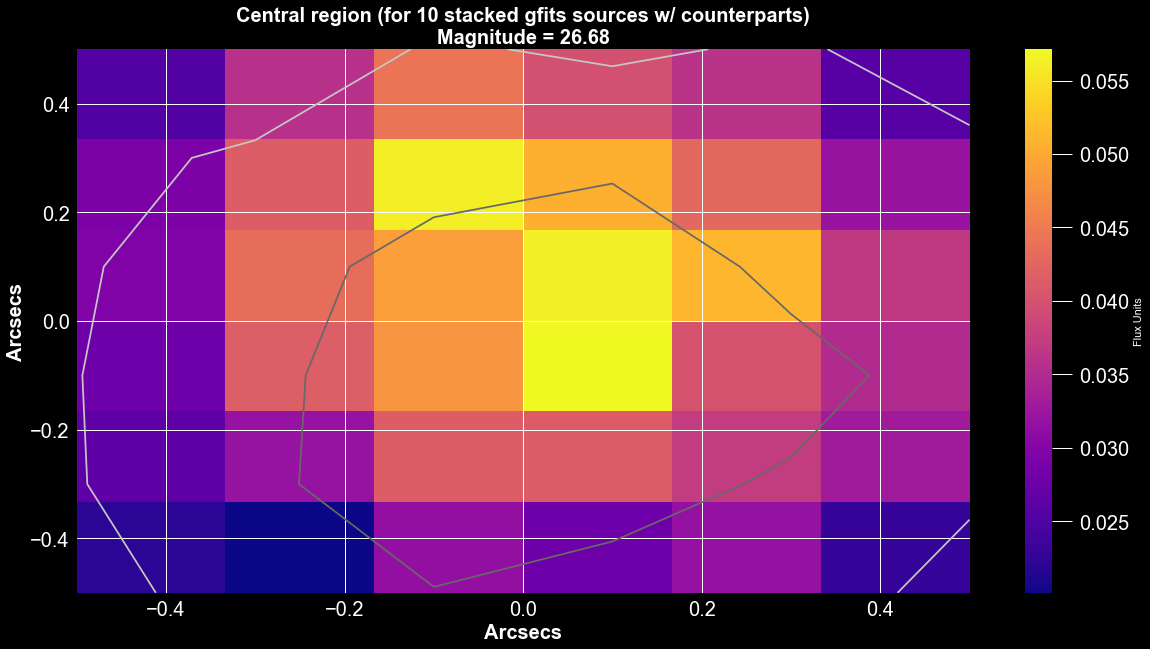

In [520]:
patch = cutout_func("gfits", df)

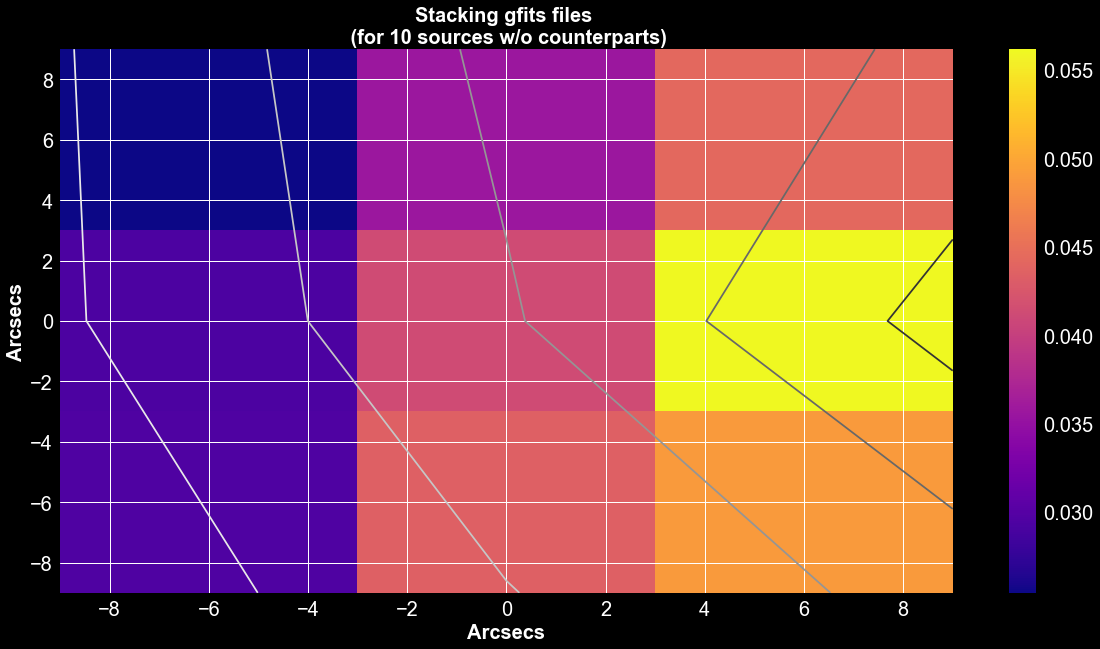

In [419]:
plt.style.use("dark_background")
fig,(ax1) = plt.subplots(1,1, figsize = (20,10))
title = "Stacking" + " " + "gfits" + " " + "files \n (for" + " " + str(result.shape[0]) + " " + "sources w/o counterparts)" 
plt.title(title, weight = "bold", size = 20)
plot = plt.imshow(patch[6:9,6:9], cmap = "plasma", extent=[-size/2 ,size/2,-size/2 ,size/2], aspect='auto')
plt.contour(patch[6:9,6:9], 5, extent=[-size/2 ,size/2,-size/2 ,size/2],cmap='Greys')
plt.xlabel("Arcsecs", weight = "bold", size = 20)
plt.ylabel("Arcsecs", weight = "bold", size = 20)
plt.tick_params("both", labelsize = 20)
cbar = fig.colorbar(plot)
cbar.ax.tick_params(labelsize=20)


